<a href="https://colab.research.google.com/github/ahinsa2001/Chili-Diseases-Classification-Model-using-Deep-Learning/blob/main/chili_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 250
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/sample_data/dataset",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 300 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Chili_yellowish', 'chili_healthy', 'chili_whitefly']

In [ ]:
len(dataset)

10

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 250, 250, 3)
[2 0 2 1 1 2 2 2 1 1 2 2 1 2 2 0 2 2 0 0 2 0 0 1 2 2 0 1 0 1 0 2]


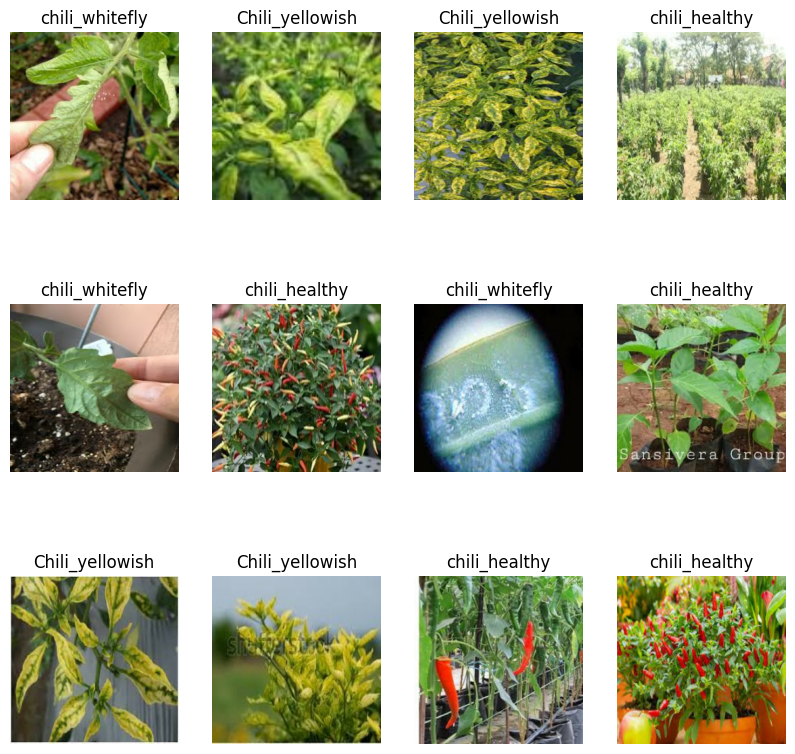

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
train_size = 0.8
len(dataset)*train_size

8.0

In [ ]:
train_ds = dataset.take(8)
len(train_ds)

8

In [ ]:
test_ds = dataset.skip(8)
len(test_ds)

2

In [ ]:
val_size = 0.1
len(dataset)*val_size

1.0

In [ ]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [ ]:
test_ds = test_ds.skip(1)
len(test_ds)

1

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

8

In [ ]:
len(val_ds)

1

In [ ]:
len(test_ds)

1

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 250, 250, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 248, 248, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 124, 124, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 122, 122, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 61, 61, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
8/8 [==============================] - 40s 4s/step - loss: 1.0700 - accuracy: 0.4023 - val_loss: 0.9343 - val_accuracy: 0.5625
Epoch 2/50
8/8 [==============================] - 34s 4s/step - loss: 0.9161 - accuracy: 0.5117 - val_loss: 0.7400 - val_accuracy: 0.6875
Epoch 3/50
8/8 [==============================] - 35s 4s/step - loss: 0.7344 - accuracy: 0.6719 - val_loss: 0.6898 - val_accuracy: 0.6562
Epoch 4/50
8/8 [==============================] - 34s 4s/step - loss: 0.6753 - accuracy: 0.7148 - val_loss: 0.5618 - val_accuracy: 0.7812
Epoch 5/50
8/8 [==============================] - 34s 4s/step - loss: 0.6139 - accuracy: 0.7578 - val_loss: 0.5231 - val_accuracy: 0.7500
Epoch 6/50
8/8 [==============================] - 32s 4s/step - loss: 0.5663 - accuracy: 0.7812 - val_loss: 0.4414 - val_accuracy: 0.7500
Epoch 7/50
8/8 [==============================] - 32s 4s/step - loss: 0.5303 - accuracy: 0.8125 - val_loss: 0.4376 - val_accuracy: 0.7812
Epoch 8/50
8/8 [==================

In [32]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 2s 2s/step - loss: 0.3177 - accuracy: 0.8438


In [33]:
scores

[0.31770288944244385, 0.84375]

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 8}

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
type(history.history['loss'])

list

In [38]:
len(history.history['loss'])

50

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

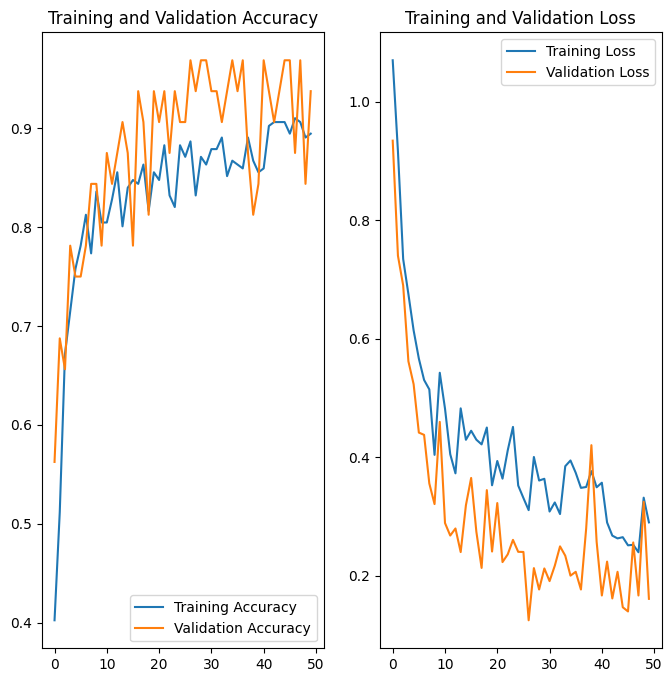

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Chili_yellowish
1/1 [==============================] - 1s 987ms/step
predicted label: Chili_yellowish


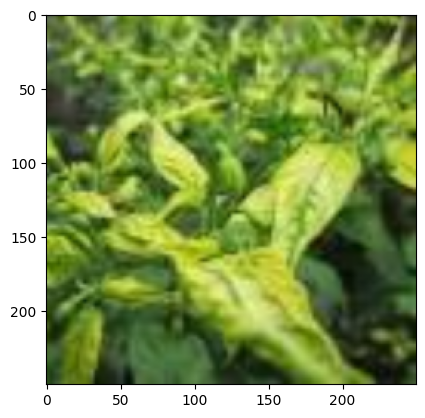

In [46]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [47]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 46ms/step


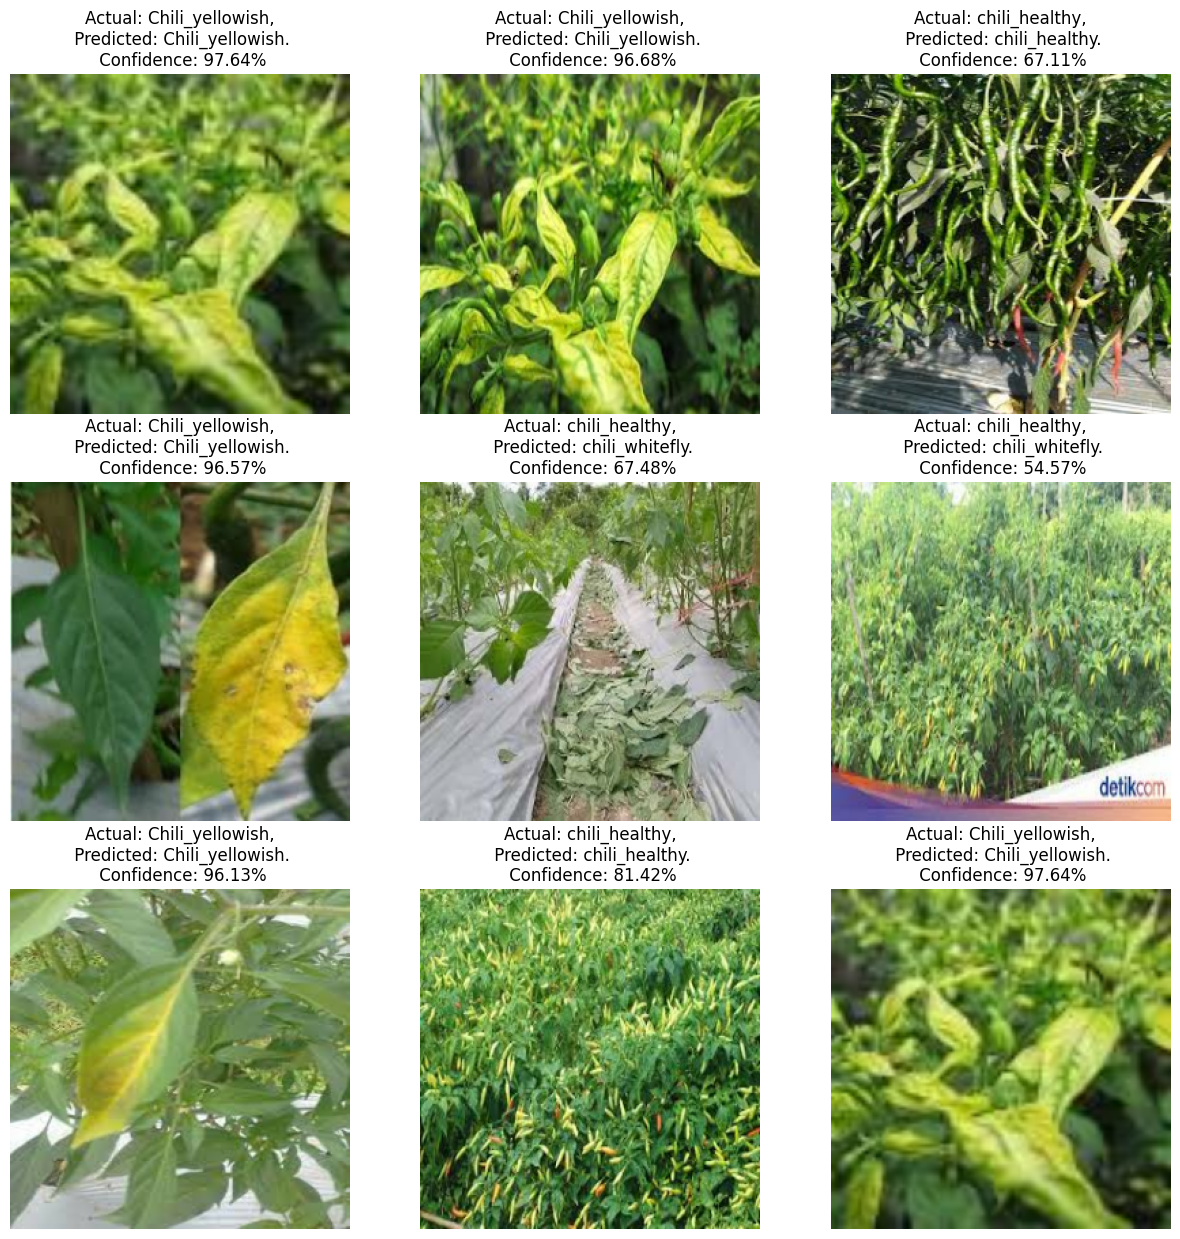

In [50]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")